In [1]:
import pandas as pd
import numpy as np
import FundInfo as fi
import seaborn as sns
from matplotlib import pyplot as plt

Tickers Reference: https://www.tsx.com/listings/listing-with-us/sector-and-product-profiles/exchange-traded-funds

In [2]:
# read data
rootDir = "../"
fundInfo = fi.FundCompositionMetrics(rootDir)

Reading ticker data from file: started


  0%|                                                                                                                                                                                                                | 0/10 [00:00<?, ?it/s]

Extracting data for tickers with no data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:39<00:00,  9.97s/it]


Reading ticker data from file: done


In [3]:
fundInfoDF = fundInfo.allFundInfoDF
#data overview
print("Total tickers : %d "%len(fundInfoDF["Ticker"]))
print("\nTotal Fund Families : %d "%len(fundInfoDF["Fund_Family"].str.lower().unique()))
print("\nTicker by Fund Families : \n%s "%(fundInfoDF["Fund_Family"].str.lower().value_counts()))

Total tickers : 749 

Total Fund Families : 37 

Ticker by Fund Families : 
blackrock/ishares      127
bmo                    109
horizons etf            90
first asset             41
vanguard canada         40
rbc etf                 34
purpose investments     26
mackenzie               25
invesco                 24
first trust             23
td                      22
fidelity                21
desjardins              19
franklin templeton      16
wisdomtree              14
harvest portfolios      12
evolve etfs             11
national bank           10
agfiq                    9
brompton                 8
manulife                 7
ci first asset           7
scotia                   6
ia clarington            6
pimco                    6
hamilton capital         5
cibc                     5
middlefield              4
russell investments      4
accelerate               4
picton mahoney           4
ci funds                 3
bristol gate             2
arrow capital            2
lysand

In [4]:
(fundInfoDF.loc[fundInfoDF["previous_close"].isnull(), "Ticker"])

15      BXS
242     ZUS
382    AUGB
383    FEBB
384    MAYB
385    NOVB
575    MEME
627     PSU
735    CHNA
739     EMV
Name: Ticker, dtype: object

In [11]:
selectedColumns = ["Ticker", "Fund_Family", "previous_close", "stocks", "bonds",
                   "priceearnings", "pricebook", "pricesales", "pricecashflow"]
dataDF = fundInfoDF.loc[:, selectedColumns]
dataDF = dataDF.dropna(subset=['previous_close'])
dataDF = dataDF.drop(dataDF[dataDF["stocks"] == "TOR"].index)

In [12]:
dataDF["Fund_Family"] = dataDF["Fund_Family"].str.lower()
dataDF[["stocks", "bonds"]] = dataDF[["stocks", "bonds"]].replace("%", "", regex=True).astype(float)
dataDF

,Ticker,Fund_Family,previous_close,stocks,bonds,priceearnings,pricebook,pricesales,pricecashflow
0,HDGE,accelerate,17.55,100.00,0.00,13.75,2.51,1.42,10.20
1,ARB,accelerate,21.82,100.00,0.00,0.00,1.95,0.95,9.36
2,ATSX,accelerate,21.11,99.99,0.00,13.60,1.63,0.97,6.85
3,ALFA,accelerate,14.19,100.00,0.00,8.09,1.27,0.48,4.31
4,QCD,agfiq,25.77,99.11,0.00,14.15,1.68,1.15,7.33
...,...,...,...,...,...,...,...,...,...
744,UMI,wisdomtree,20.31,99.88,0.00,13.72,1.44,1.17,7.51
745,DGR,wisdomtree,27.73,99.93,0.00,19.12,4.59,1.90,11.96
746,DQD,wisdomtree,28.77,99.91,0.00,21.17,4.98,2.01,12.41
747,CAGG,wisdomtree,53.19,0.00,98.05,0.00,0.00,0.00,0.00


Text(0.5, 1.0, 'Fund Composition')

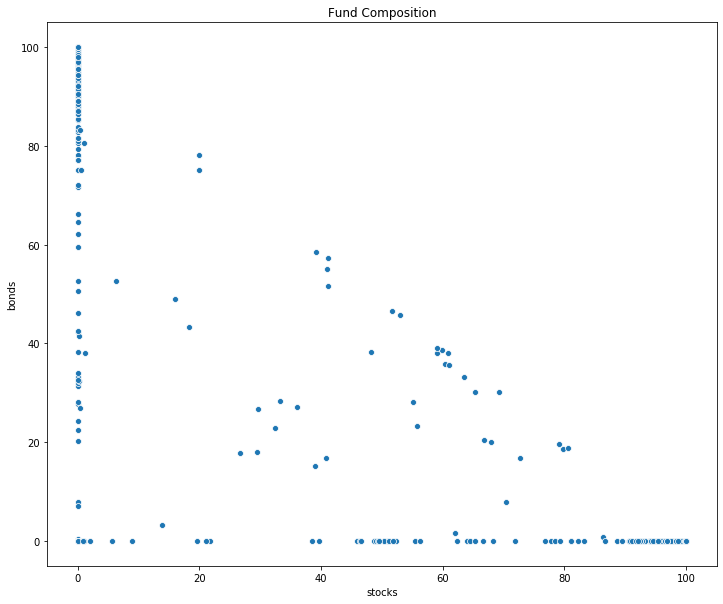

In [13]:
fig, ax = plt.subplots(figsize = (12, 10))
sns.scatterplot(data=dataDF, x="stocks", y="bonds", ax=ax)
ax.set_title("Fund Composition")


Text(0.5, 1.0, 'Ratios')

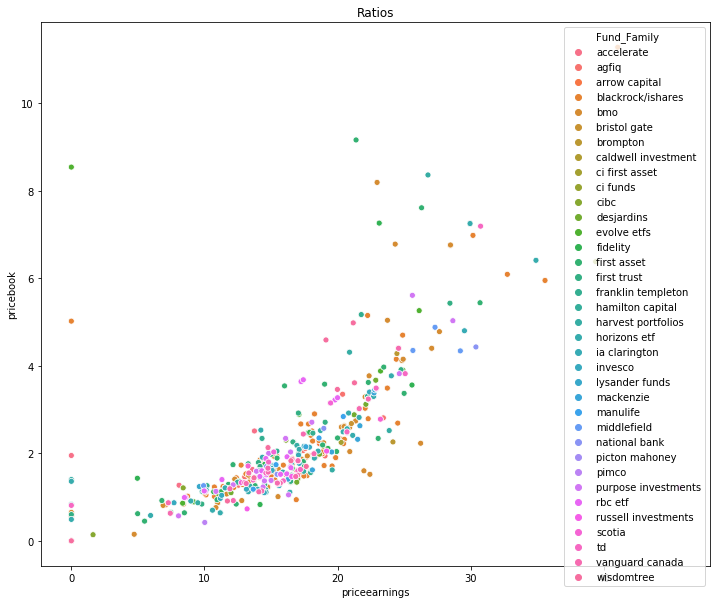

In [14]:
fig, ax = plt.subplots(figsize = (12, 10))
sns.scatterplot(data=dataDF, x="priceearnings", y="pricebook", hue="Fund_Family", ax=ax)
ax.set_title("Ratios")


In [16]:
from sklearn.cluster import KMeans

trainData = dataDF[["stocks", "bonds"]].dropna()

clusterNames = ["Equity", "FixedIncome", "Commodity", "Balanced"]

clusters = KMeans(n_clusters=4, random_state=0).fit(trainData)

trainData["asset_type"] = [clusterNames[label] for label in clusters.labels_]

centroids = clusters.cluster_centers_
print(centroids)

[[52.73883333 16.38083333]
 [ 0.32691275 90.95288591]
 [98.28859694  0.0992602 ]
 [ 1.35515464  7.27278351]]


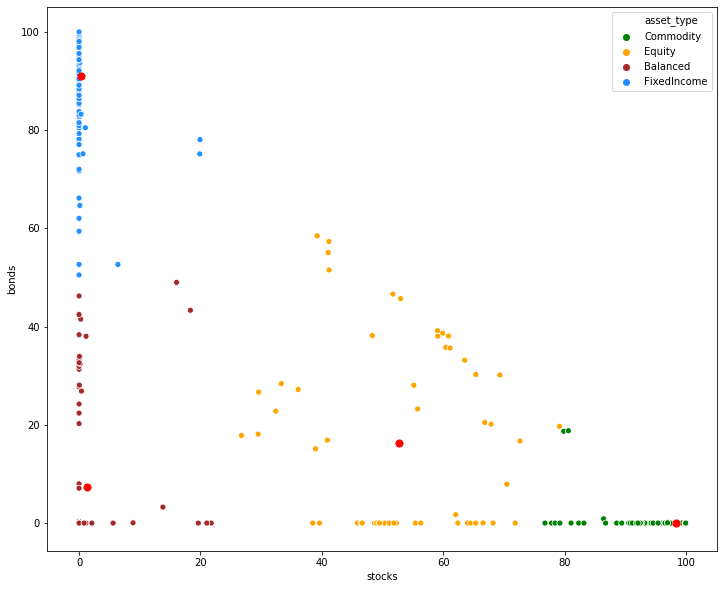

In [17]:
fig, ax = plt.subplots(figsize = (12, 10))
sns.scatterplot(data=trainData, x="stocks", y="bonds", hue="asset_type", ax=ax, palette=['green','orange','brown','dodgerblue'])
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)


In [18]:
trainData.groupby("asset_type").count()

,stocks,bonds
asset_type,,
Balanced,97,97
Commodity,392,392
Equity,60,60
FixedIncome,149,149
